# Load the libraries


In [2]:
import warnings
warnings.filterwarnings("ignore")
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sb
from pandas.tools.plotting import scatter_matrix


import sklearn

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import Imputer
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE 

from xgboost import XGBClassifier

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


import kers

In [4]:
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


# TASK.1: EXPLORATORY ANALYSIS

# Read the Data and convert it to a dataframe.

In [5]:
file_path = '/Users/bank-additional-full.csv'

#banking_data = read_data(file_path)
banking_data = pd.read_csv(file_path, sep=";" )


# Let's take a look at the data and see what we have:

In [6]:
banking_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


There are many 'nonexistent' values under Categorical variables. I have to go back to those and take care of them.

In [7]:
banking_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

In [8]:
categorical_vars = banking_data.describe(include=["object"]).columns
numerical_vars = banking_data.describe().columns
print("number of categorical variables",len(categorical_vars))
print("number of numerical variables",len(numerical_vars))

number of categorical variables 11
number of numerical variables 10


41188 observation and 21 columns, among which 10 columns are numerical and 11 are categorical 

# Now let's take a look at the response variable:

In [9]:
label_distribution = banking_data.groupby(['y']).size()
label_distribution_normalized = (label_distribution/len(banking_data))*100
print(label_distribution_normalized)

y
no     88.734583
yes    11.265417
dtype: float64


Let's craete the bar plot on the response column: 

Text(0.5,1,'Response columns distributiomn')

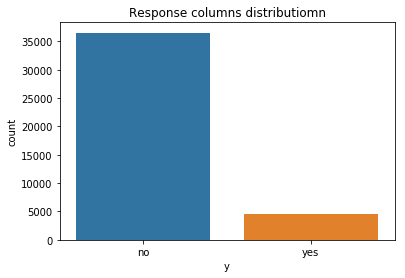

In [10]:
sb.countplot(x='y', data=banking_data)
ax = plt.gca()
ax.set_title('Response columns distributiomn')

The first thing we observe is that the distribution of the response column is imbalanced in facvor of the negative class, i.e.  approx 88% is 'no' and 11% is 'yes'.

## The class distributions is imbalanced, will take this into account when I am thinking about making improvements

In [11]:
banking_data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [12]:
banking_data.describe(include=["object"])

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


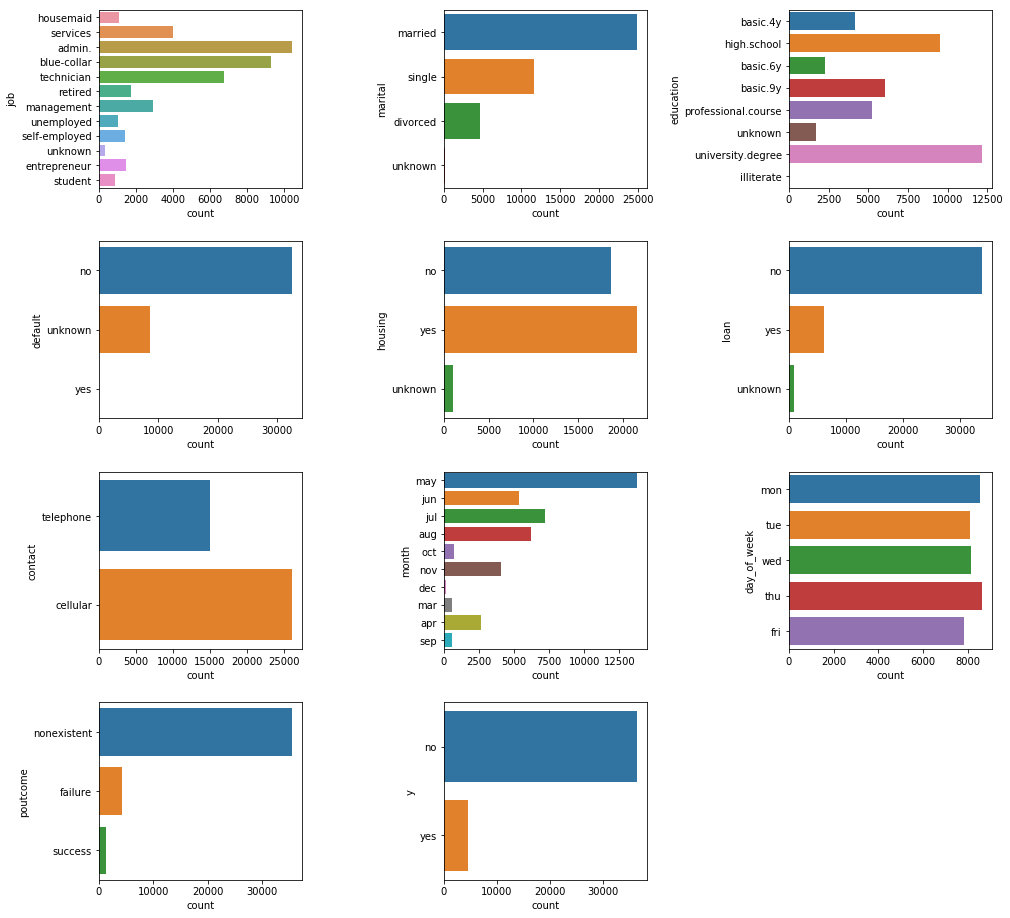

In [13]:
fig, axes = plt.subplots(4, 3, figsize=(16, 16))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.7, hspace=0.3)

for i, ax in enumerate(axes.ravel()):
    if i > 10:
        ax.set_visible(False)
        continue
    sb.countplot(y = categorical_vars[i], data=banking_data, ax=ax)

Afew things to notice:
    1- alot of nonexistant in poutcome, 35563 out of 41188
    2- alot of unknown in defaults. should we impute unknowns or just take 'unknown' as a feature

## Now lets take a look at the correlation between numerical features. 

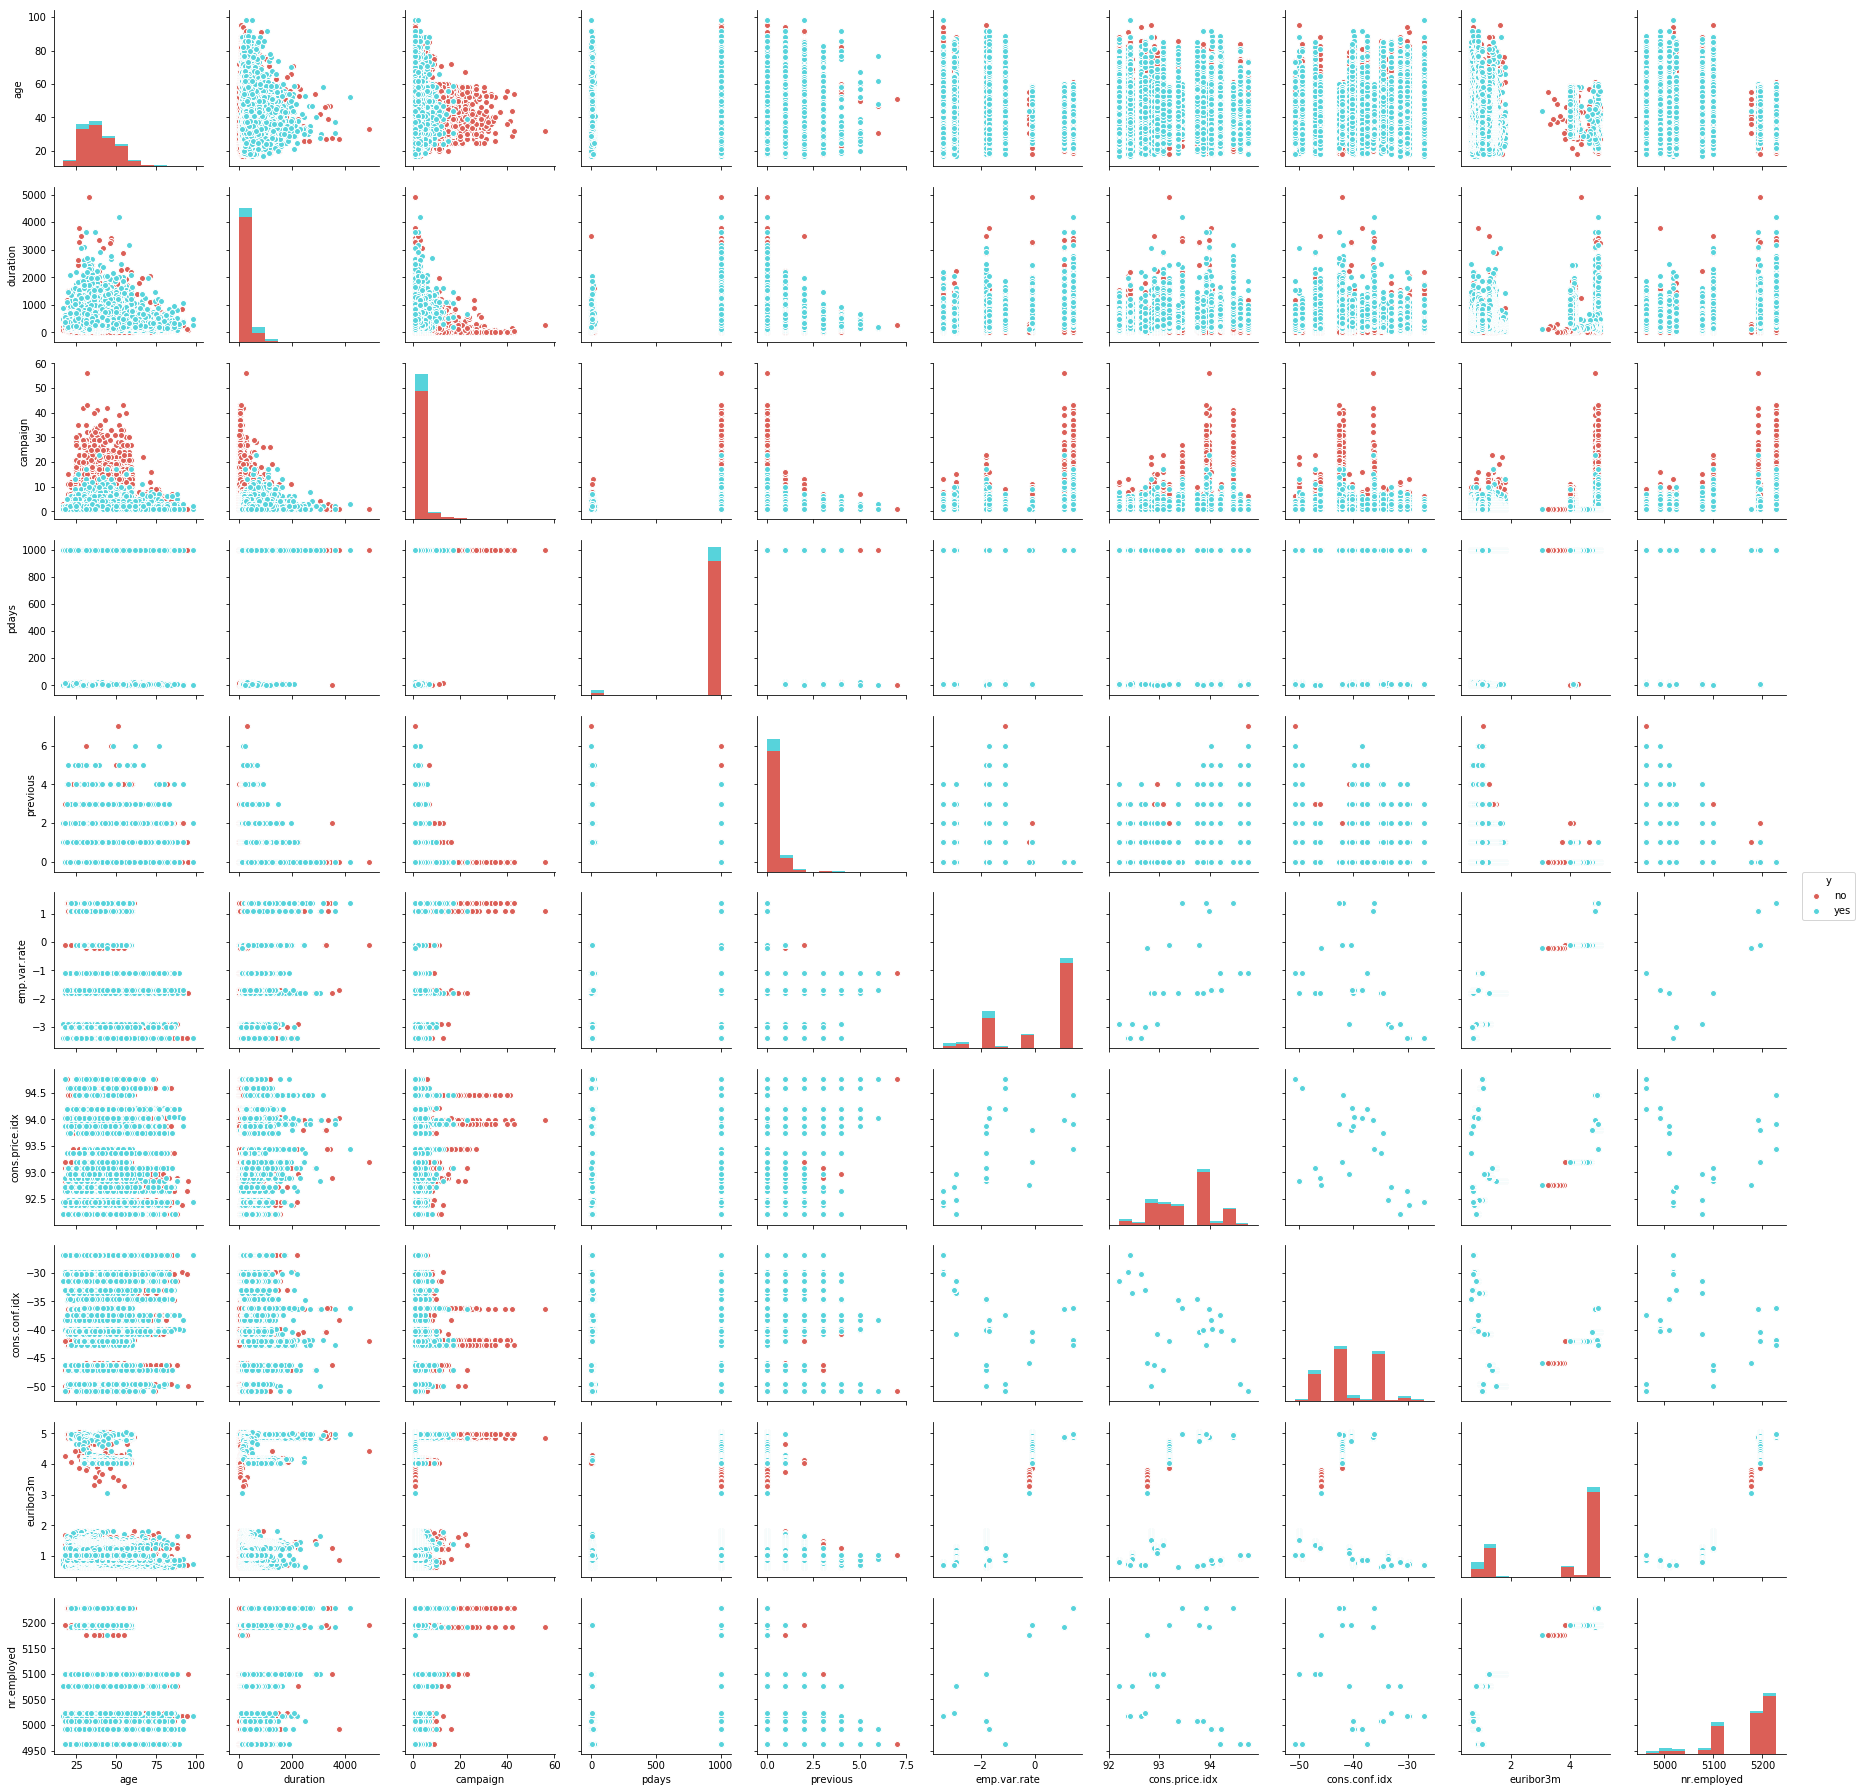

In [14]:
sb.pairplot(banking_data, hue='y', palette='hls')

no clear orrelation among teh pairs so I am not worried about colinearity which is good.

# Analyzing Independent Numerical variables against Target variable

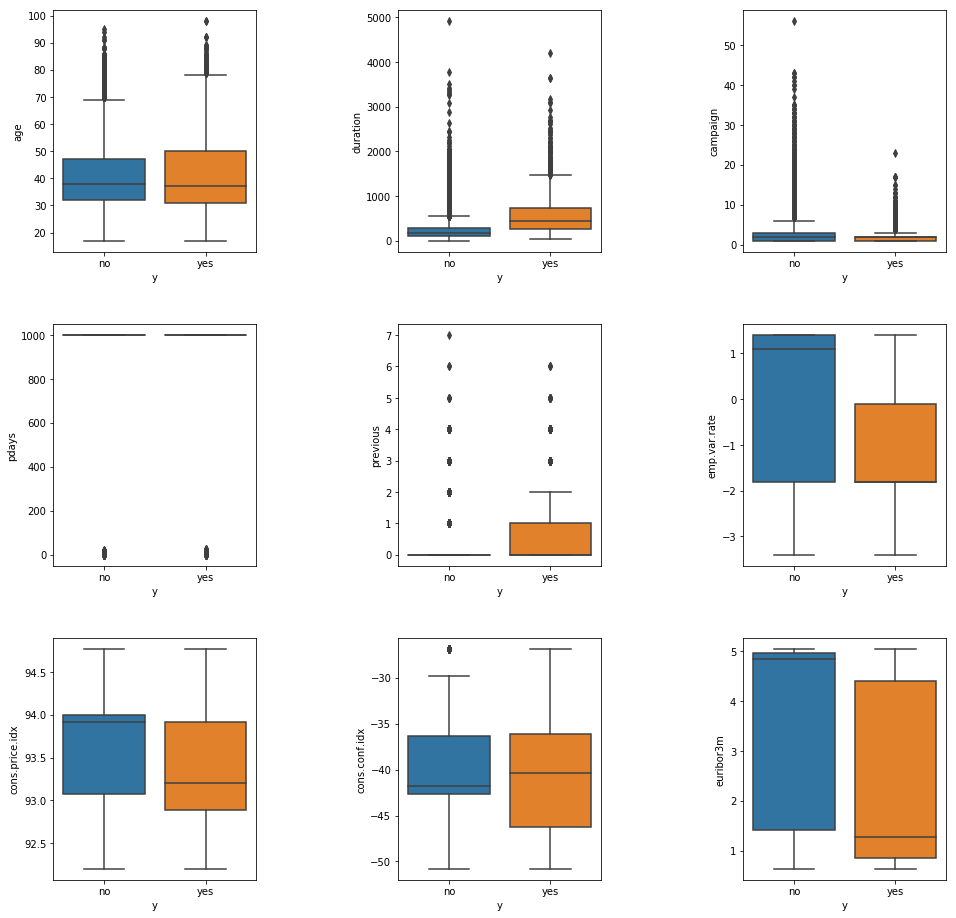

In [15]:
fig, axes = plt.subplots(3, 3, figsize=(16, 16))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.7, hspace=0.3)
for i, ax in enumerate(axes.ravel()):
    if i > 15:
        ax.set_visible(False)
        continue
    sb.boxplot(y = numerical_vars[i], x = 'y', data=banking_data, ax=ax)

# Feature Engeering

In [16]:
y_raw = banking_data['y']
x_raw = banking_data[banking_data.columns[0:-1]]

converting the response variable to numerical

In [18]:
le = LabelEncoder()
y = le.fit_transform(y_raw)

converting categorical features into numeriacal by creating dummy variables

In [20]:
x = pd.get_dummies(x_raw)
print(x.head(5))

   age  duration  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
0   56       261         1    999         0           1.1          93.994   
1   57       149         1    999         0           1.1          93.994   
2   37       226         1    999         0           1.1          93.994   
3   40       151         1    999         0           1.1          93.994   
4   56       307         1    999         0           1.1          93.994   

   cons.conf.idx  euribor3m  nr.employed        ...         month_oct  \
0          -36.4      4.857       5191.0        ...                 0   
1          -36.4      4.857       5191.0        ...                 0   
2          -36.4      4.857       5191.0        ...                 0   
3          -36.4      4.857       5191.0        ...                 0   
4          -36.4      4.857       5191.0        ...                 0   

   month_sep  day_of_week_fri  day_of_week_mon  day_of_week_thu  \
0          0                0  

# TASK2. CREATING MODELS- START WITH BASELINE AND SEE WHAT WE GET WITH NO MODIFICATIONS

# Make the Baseline 

In [38]:
# Let's start with a few models, simple ones like logistic regression, KNN and decision tree. 
#ensemble models like random forest and XGBoost and a nonlinearn one like SVM
seed = 7
scoring = 'accuracy'
models = []
models.append(('LR', LogisticRegression()))
#models.append(('SVM', SVC()))
models.append(('K-NN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF',RandomForestClassifier()))
models.append(('XGB',XGBClassifier()))


Split the data to train and test

In [156]:
test_size = 0.20
#x=scale(x)
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(x, y, test_size=test_size, random_state=seed)

In [157]:


def rocplots(Y_test, preds,  model_name):
    
    fpr, tpr, threshold = metrics.roc_curve(Y_test, preds, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    plt.rcParams["figure.figsize"] = (4,4)
    plt.title('Receiver Operating Characteristic {}'.format(model_name))
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    

In [158]:
def run_models(models):
    for name, model in models:
        scores = cross_val_score(model,X_train, Y_train, cv =10, scoring = 'accuracy')
        print("average accuracy for {} is {}".format(name,scores.mean()))
        start_time = time.time
        start = time.time()
        model.fit(X_train, Y_train)
        print ("Training for ", name, " took", time.time() - start, "seconds.")
        predictions = model.predict(X_test)
        print("Accuracy : ", accuracy_score(Y_test, predictions))
        print(confusion_matrix(Y_test, predictions))
        print(classification_report(Y_test, predictions))
        probs = model.predict_proba(X_test)
        preds = probs[:,1]
        fpr, tpr, threshold = metrics.roc_curve(Y_test, preds, pos_label=1)
        roc_auc = metrics.auc(fpr, tpr)
        print("AUC : ", roc_auc)
        rocplots(Y_test, preds,  name)
    
    
    

average accuracy for LR is 0.9106830011612758
Training for  LR  took 0.7675571441650391 seconds.
Accuracy :  0.9126001456664239
[[7135  198]
 [ 522  383]]
             precision    recall  f1-score   support

          0       0.93      0.97      0.95      7333
          1       0.66      0.42      0.52       905

avg / total       0.90      0.91      0.90      8238

AUC :  0.9337219999201368


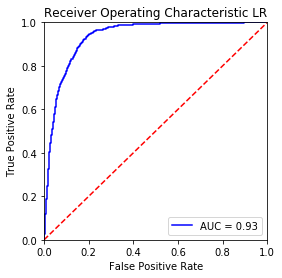

average accuracy for K-NN is 0.8961461630737853
Training for  K-NN  took 1.717583179473877 seconds.
Accuracy :  0.8956057295460063
[[7122  211]
 [ 649  256]]
             precision    recall  f1-score   support

          0       0.92      0.97      0.94      7333
          1       0.55      0.28      0.37       905

avg / total       0.88      0.90      0.88      8238

AUC :  0.7918278304463362


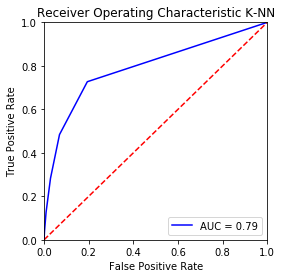

average accuracy for CART is 0.8898033383733885
Training for  CART  took 0.27301812171936035 seconds.
Accuracy :  0.8945132313668366
[[6891  442]
 [ 427  478]]
             precision    recall  f1-score   support

          0       0.94      0.94      0.94      7333
          1       0.52      0.53      0.52       905

avg / total       0.90      0.89      0.89      8238

AUC :  0.7339506642567128


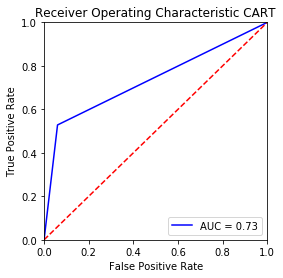

average accuracy for RF is 0.9085888729729252
Training for  RF  took 0.28174519538879395 seconds.
Accuracy :  0.907623209516873
[[7119  214]
 [ 547  358]]
             precision    recall  f1-score   support

          0       0.93      0.97      0.95      7333
          1       0.63      0.40      0.48       905

avg / total       0.90      0.91      0.90      8238

AUC :  0.9067486492982226


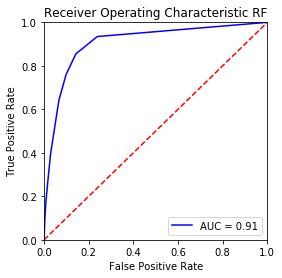

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

average accuracy for XGB is 0.9157209747348813
Training for  XGB  took 2.725198984146118 seconds.
Accuracy :  0.9167273610099539
[[7088  245]
 [ 441  464]]
             precision    recall  f1-score   support

          0       0.94      0.97      0.95      7333
          1       0.65      0.51      0.57       905

avg / total       0.91      0.92      0.91      8238

AUC :  0.9478477298943021


/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


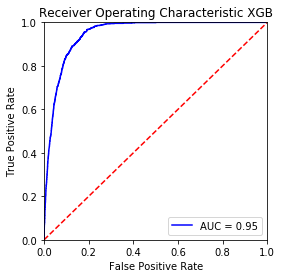

In [159]:
run_models(models)

XGboost with precision=0.66 and recall = 0.51 and F1score =0.91 is the best results that I have got so far, however the training time is the longest as well.  Let see if we can get better results if we do oversampling (giving higher weights to the negative class). It is worth noting that the SVM model took a long time to train and I just gave up on it. 

# Imbalnced Data and so lets weight the class that is in minority

Resampled dataset shape Counter({0: 29215, 1: 29215})
average accuracy for LR is 0.8864801160188875
Training for  LR  took 1.9922189712524414 seconds.
Accuracy :  0.8651371692158291
[[6333 1000]
 [ 111  794]]
             precision    recall  f1-score   support

          0       0.98      0.86      0.92      7333
          1       0.44      0.88      0.59       905

avg / total       0.92      0.87      0.88      8238

AUC :  0.9357306296443912


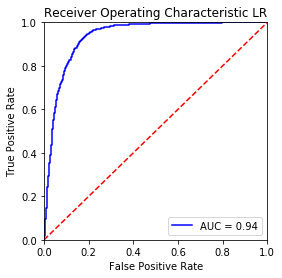

average accuracy for K-NN is 0.9174909392463787
Training for  K-NN  took 6.648869752883911 seconds.
Accuracy :  0.8318766690944404
[[6255 1078]
 [ 307  598]]
             precision    recall  f1-score   support

          0       0.95      0.85      0.90      7333
          1       0.36      0.66      0.46       905

avg / total       0.89      0.83      0.85      8238

AUC :  0.8159298802883808


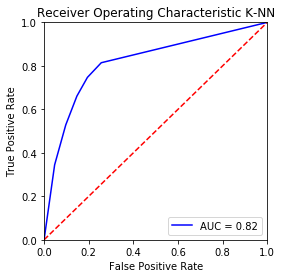

average accuracy for CART is 0.9227146772375263
Training for  CART  took 0.7907009124755859 seconds.
Accuracy :  0.8826171400825443
[[6761  572]
 [ 395  510]]
             precision    recall  f1-score   support

          0       0.94      0.92      0.93      7333
          1       0.47      0.56      0.51       905

avg / total       0.89      0.88      0.89      8238

AUC :  0.7427661829932501


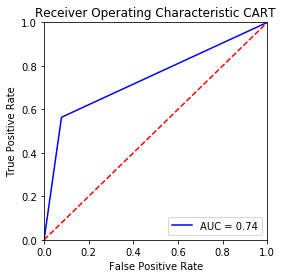

average accuracy for RF is 0.9513300450536264
Training for  RF  took 0.7542049884796143 seconds.
Accuracy :  0.9119932022335518
[[7038  295]
 [ 430  475]]
             precision    recall  f1-score   support

          0       0.94      0.96      0.95      7333
          1       0.62      0.52      0.57       905

avg / total       0.91      0.91      0.91      8238

AUC :  0.9282754188475167


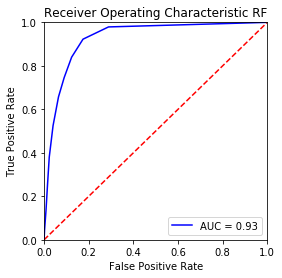

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

average accuracy for XGB is 0.9290630746083085
Training for  XGB  took 6.1378700733184814 seconds.
Accuracy :  0.8953629521728574
[[6645  688]
 [ 174  731]]
             precision    recall  f1-score   support

          0       0.97      0.91      0.94      7333
          1       0.52      0.81      0.63       905

avg / total       0.92      0.90      0.91      8238

AUC :  0.94155889557009


/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


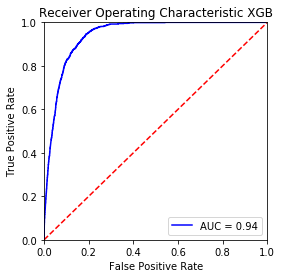

In [161]:

sm = SMOTE(random_state=42)
X_train, Y_train = sm.fit_sample(X_train, Y_train)
print('Resampled dataset shape {}'.format(Counter(Y_train)))
sm
run_models(models)


Interestingly oversampling is helping with recall. XGBoost on the obversampled data is givin us teh best AUC and very high recall =0.81 on the positive class

## Check if any dimensionality reduction will help improve or expedicte the solution

In [ ]:
I use PCA for dimensionality reduction

[  9.5   14.2   18.24  22.05  25.72  28.85  31.91  34.77  37.49  40.18
  42.82  45.36  47.81  50.07  52.1   54.11  56.1   58.07  60.02  61.92
  63.79  65.59  67.34  69.06  70.76  72.44  74.1   75.74  77.37  78.98
  80.58  82.16  83.73  85.29  86.82  88.32  89.74  91.13  92.47  93.75
  94.91  96.03  96.99  97.69  98.35  98.99  99.37  99.72  99.92  99.99
 100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
 100.   100.   100.  ]


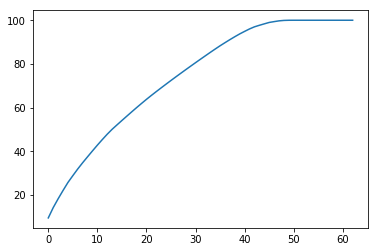

In [46]:
#initially lets create 63 components which is actual number of Variables we have
normalized_x =  scale(x)
pca = PCA(n_components=63)
pca.fit(normalized_x)
#The amount of variance that each principle explains
var= pca.explained_variance_ratio_

#Cumulative Variance explained
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(var)
plt.plot(var)



It looks like that with 45 principles, 99% of the vaiations in teh data is explained. So I will go with 45 principles

average accuracy for LR is 0.9088923631374491
Training for  LR  took 0.2955667972564697 seconds.
Accuracy :  0.9098082058752124
[[7132  201]
 [ 542  363]]
             precision    recall  f1-score   support

          0       0.93      0.97      0.95      7333
          1       0.64      0.40      0.49       905

avg / total       0.90      0.91      0.90      8238

AUC :  0.9304634389458686


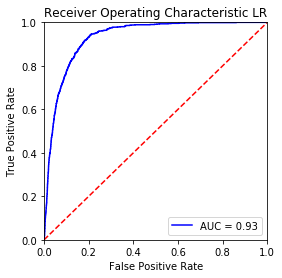

average accuracy for K-NN is 0.8948412014194682
Training for  K-NN  took 0.07499122619628906 seconds.
Accuracy :  0.896698227725176
[[7122  211]
 [ 640  265]]
             precision    recall  f1-score   support

          0       0.92      0.97      0.94      7333
          1       0.56      0.29      0.38       905

avg / total       0.88      0.90      0.88      8238

AUC :  0.7902025431090665


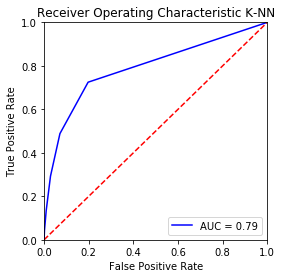

average accuracy for CART is 0.8727477253435196
Training for  CART  took 3.2533600330352783 seconds.
Accuracy :  0.8772760378732702
[[6809  524]
 [ 487  418]]
             precision    recall  f1-score   support

          0       0.93      0.93      0.93      7333
          1       0.44      0.46      0.45       905

avg / total       0.88      0.88      0.88      8238

AUC :  0.6952103297513021


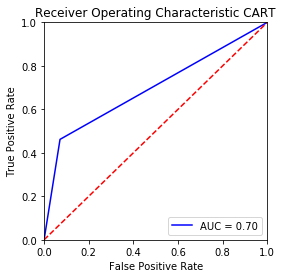

average accuracy for RF is 0.9021557288627159
Training for  RF  took 2.3632261753082275 seconds.
Accuracy :  0.9009468317552805
[[7126  207]
 [ 609  296]]
             precision    recall  f1-score   support

          0       0.92      0.97      0.95      7333
          1       0.59      0.33      0.42       905

avg / total       0.88      0.90      0.89      8238

AUC :  0.8931766109911072


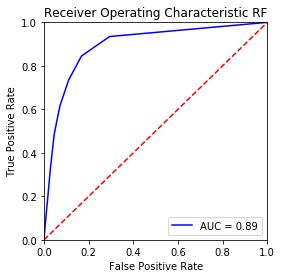

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

average accuracy for XGB is 0.9068591356158004
Training for  XGB  took 7.405555009841919 seconds.
Accuracy :  0.9081087642631707
[[7117  216]
 [ 541  364]]
             precision    recall  f1-score   support

          0       0.93      0.97      0.95      7333
          1       0.63      0.40      0.49       905

avg / total       0.90      0.91      0.90      8238

AUC :  0.9330957534734754


/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


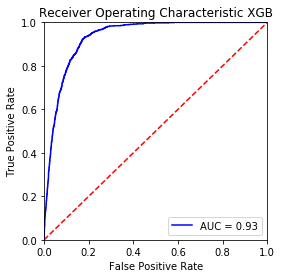

In [49]:
pca = PCA(n_components=45)
pca.fit(normalized_x)
x_45PC=pca.fit_transform(normalized_x)
seed = 7
test_size = 0.20
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(x_45PC, y, test_size=test_size, random_state=seed)
run_models(models)

PCA is not helping with the accuracy. SVM takes a long time to train the model, so PCA might be helpful in that regard if we go with a smaller number of principle components. 


# TASK3. USE DEEP LEARNING TO SEE IF IT IMPROVES YOUR RESULTS

# Using Deep learning

In [145]:
model = Sequential()
#started with 10 nodes in the hidden layer and went up to 40, 
#tried relu, tanh and sigmoid and sigmoid gave teh best results
model.add(Dense(30, input_dim=63, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

In [146]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [147]:
seed = 7
test_size = 0.20
#tried with and without scale and did not see a huge difference
#x=scale(x)
x_train_keras = np.array(x)
y_train_keras = np.array(y)
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(x_train_keras, y_train_keras, test_size=test_size, random_state=seed)
Y_train = Y_train.reshape(Y_train.shape[0], 1)
print(type(Y_train))

<class 'numpy.ndarray'>


In [148]:
model.fit(np.array(X_train), np.array(Y_train), epochs=50, batch_size=200, shuffle=True)

Epoch 1/50
32950/32950 [==============================] - 0s 14us/step - loss: 0.6730 - acc: 0.5981
Epoch 2/50
32950/32950 [==============================] - 0s 5us/step - loss: 0.2964 - acc: 0.8957
Epoch 3/50
32950/32950 [==============================] - 0s 5us/step - loss: 0.2441 - acc: 0.9011
Epoch 4/50
32950/32950 [==============================] - 0s 5us/step - loss: 0.2249 - acc: 0.9044
Epoch 5/50
32950/32950 [==============================] - 0s 5us/step - loss: 0.2133 - acc: 0.9062
Epoch 6/50
32950/32950 [==============================] - 0s 5us/step - loss: 0.2055 - acc: 0.9088
Epoch 7/50
32950/32950 [==============================] - 0s 5us/step - loss: 0.2003 - acc: 0.9099
Epoch 8/50
32950/32950 [==============================] - 0s 5us/step - loss: 0.1966 - acc: 0.9105
Epoch 9/50
32950/32950 [==============================] - 0s 5us/step - loss: 0.1940 - acc: 0.9110
Epoch 10/50
32950/32950 [==============================] - 0s 5us/step - loss: 0.1922 - acc: 0.9117
Epoch 11

In [149]:
scores = model.evaluate(np.array(X_test), np.array(Y_test))

8238/8238 [==============================] - 0s 22us/step


In [150]:
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


acc: 91.58%


AUC :  0.9424578063442863


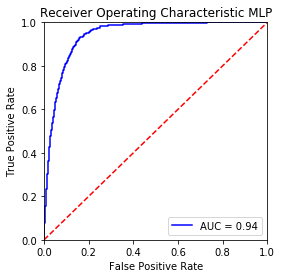

In [151]:

probs = model.predict_proba(X_test)
fpr, tpr, threshold = metrics.roc_curve(Y_test, probs, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
print("AUC : ", roc_auc)
rocplots(Y_test, probs,  'MLP')
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)


XGboost was better than deep learning when it comes to AUC

In [162]:
seed = 7
test_size = 0.20
#tried with and without scale and did not see a huge difference
#x=scale(x)
x_train_keras = np.array(x)
y_train_keras = np.array(y)
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(x_train_keras, y_train_keras, test_size=test_size, random_state=seed)
sm = SMOTE(random_state=42)
X_train, Y_train = sm.fit_sample(X_train, Y_train)
Y_train = Y_train.reshape(Y_train.shape[0], 1)

model = Sequential()
#started with 10 nodes in the hidden layer and went up to 40, 
#tried relu, tanh and sigmoid and sigmoid gave teh best results
model.add(Dense(30, input_dim=63, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(np.array(X_train), np.array(Y_train), epochs=50, batch_size=200, shuffle=True)


<class 'numpy.ndarray'>
Epoch 1/50
58430/58430 [==============================] - 1s 11us/step - loss: 0.4678 - acc: 0.7988
Epoch 2/50
58430/58430 [==============================] - 0s 5us/step - loss: 0.3277 - acc: 0.8772
Epoch 3/50
58430/58430 [==============================] - 0s 6us/step - loss: 0.2941 - acc: 0.8873
Epoch 4/50
58430/58430 [==============================] - 0s 6us/step - loss: 0.2843 - acc: 0.8899
Epoch 5/50
58430/58430 [==============================] - 0s 5us/step - loss: 0.2794 - acc: 0.8917
Epoch 6/50
58430/58430 [==============================] - 0s 6us/step - loss: 0.2753 - acc: 0.8946
Epoch 7/50
58430/58430 [==============================] - 0s 5us/step - loss: 0.2715 - acc: 0.8953
Epoch 8/50
58430/58430 [==============================] - 0s 7us/step - loss: 0.2677 - acc: 0.8969
Epoch 9/50
58430/58430 [==============================] - 0s 6us/step - loss: 0.2643 - acc: 0.8980
Epoch 10/50
58430/58430 [==============================] - 0s 7us/step - loss: 0.260

8238/8238 [==============================] - 0s 14us/step

acc: 87.92%
AUC :  0.9371214512764142


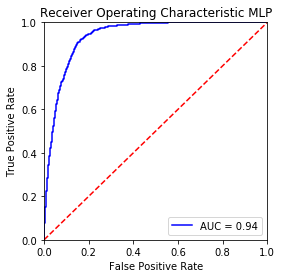

[[6502  831]
 [ 164  741]]
             precision    recall  f1-score   support

          0       0.98      0.89      0.93      7333
          1       0.47      0.82      0.60       905

avg / total       0.92      0.88      0.89      8238



In [167]:
scores = model.evaluate(np.array(X_test), np.array(Y_test))
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
probs = model.predict_proba(X_test)
fpr, tpr, threshold = metrics.roc_curve(Y_test, probs, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
print("AUC : ", roc_auc)
rocplots(Y_test, probs,  'MLP')
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

print(confusion_matrix(Y_test, y_pred))
print(classification_report(Y_test, y_pred))


In [ ]:
## By oversampling, deep learning based model gets a very good recall but it is sacrificing precision. Conclusion is that the XGBoost with oversampling is the best result  